In [1]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_driver_ids = pd.read_csv("driver_ids.csv")
df_ride_ids = pd.read_csv("ride_ids.csv")
df_ride_timestamps = pd.read_csv("ride_timestamps.csv")
print(df_driver_ids.columns)
print(df_ride_ids.columns)
print(df_ride_timestamps.columns)
df_ride_timestamps['timestamp']= pd.to_datetime(df_ride_timestamps['timestamp'])
df_driver_ids['driver_onboard_date']= pd.to_datetime(df_driver_ids['driver_onboard_date'])
df_ride_timestamps = df_ride_timestamps.dropna(how = "any")

# no na values except one timestamp

Index(['driver_id', 'driver_onboard_date'], dtype='object')
Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time'],
      dtype='object')
Index(['ride_id', 'event', 'timestamp'], dtype='object')


In [3]:
def fixMinMax(fare):
    if fare < 5:
        fare = 5
    if fare > 400:
        fare = 400
    return round(fare, 2)
def primeTimeX(value):
    if value > 0:
        return value/100
    else:
        return 1
df_ride_ids['primeMultiplicator'] = df_ride_ids['ride_prime_time'].map(primeTimeX)
df_ride_ids['fare'] = (3.75 + 1.15*(df_ride_ids['ride_distance']/1609) + 
                       0.22*(df_ride_ids['ride_duration']/60)) * (1 + df_ride_ids['primeMultiplicator'])
df_ride_ids['adjusted_fare'] = df_ride_ids['fare'].map(fixMinMax)
df_ride_ids.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,primeMultiplicator,fare,adjusted_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,0.50,9.365063,9.37
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,1.00,18.238509,18.24
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,1.00,16.386152,16.39
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,0.25,78.311286,78.31
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,1.00,19.417558,19.42


In [4]:
df_ride_deets= df_ride_timestamps.pivot(index='ride_id',columns='event',values='timestamp').reset_index()
print(len(df_ride_deets))
# print(len(df_ride_deets), len(df_ride_ids))
# print(len(df_ride_deets) - len(df_ride_ids)) # should be 579
# print(df_ride_timestamps['ride_id'].nunique() - df_ride_ids['ride_id'].nunique()) # should be 579
# print(df_ride_deets['ride_id'].nunique() - df_ride_ids['ride_id'].nunique()) # should be 579
# print(len(df_ride_deets) - df_ride_timestamps['ride_id'].nunique()) # should be 0

df_ride_deets = pd.merge(df_ride_ids, df_ride_deets, left_on = 'ride_id', right_on = 'ride_id', how = 'inner')
# print(len(df_ride_deets) - len(df_ride_ids)) # should be equal now
# print(df_ride_deets['ride_id'].nunique() - df_ride_ids['ride_id'].nunique())
# print(len(df_ride_deets), len(df_ride_ids))
# 529 rides present in df_ride_timestamps have been deleted
print(len(df_ride_deets))

# print(df_ride_deets['driver_id'].nunique()) # every driver has at least one ride
df_ride_deets = pd.merge(df_ride_deets, df_driver_ids, left_on = 'driver_id', right_on = 'driver_id')
print(len(df_ride_deets))
# print(df_ride_deets.head(5))
# print(df_ride_deets['driver_id'].nunique())

194081
184819
184209


In [5]:
df_ride_deets['ride_day-onboard'] = (df_ride_deets['accepted_at']- df_ride_deets['driver_onboard_date']).dt.days
df_ride_deets['accepted-requested'] = (df_ride_deets['accepted_at']- df_ride_deets['requested_at']).dt.seconds
df_ride_deets['arrived-accepted'] = (df_ride_deets['arrived_at']- df_ride_deets['accepted_at']).dt.seconds
df_ride_deets['pickedup-arrived'] = (df_ride_deets['picked_up_at']- df_ride_deets['arrived_at']).dt.seconds
df_ride_deets['dropped-picked'] = (df_ride_deets['dropped_off_at']- df_ride_deets['picked_up_at']).dt.seconds
df_ride_deets['day_of_week'] = df_ride_deets['dropped_off_at'].dt.dayofweek
print(df_ride_deets.head(5))

                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  primeMultiplicator  \
0           1811            327               50                0.50   
1           3362            809                0                1.00   
2           3282            572                0                1.00   
3          65283           3338               25                0.25   
4           4115            823              100                1.00   

        fare  adjusted_fare         accepted_at          arrived_at  \
0   9.365063           9.37 2016-04-23 02:14:15 2016-04-2

In [6]:
df_ride_deets.shape

(184209, 20)

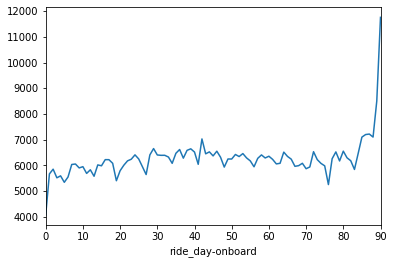

In [7]:
df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()

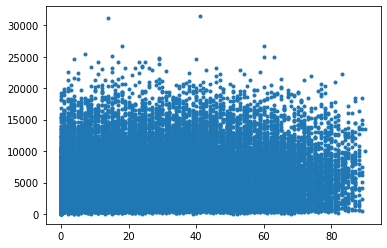

In [8]:
l = df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index()
l.columns
plt.plot('ride_day-onboard', 'ride_duration', data = l, marker='.', linestyle = 'None')

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 10 Text xticklabel objects>)

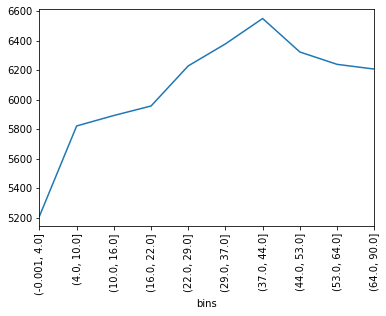

In [9]:
l = df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index()
m = pd.qcut(l['ride_day-onboard'], 10)
l['bins'] = m
l.groupby('bins')['ride_duration'].agg("mean").plot()
plt.xticks(rotation=90)

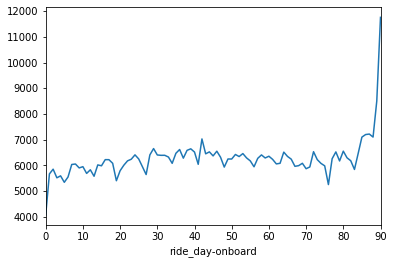

In [10]:
df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()

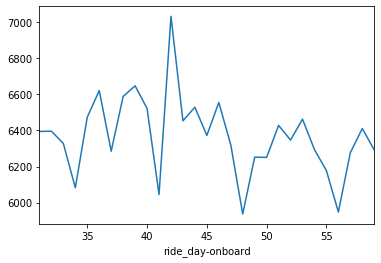

In [11]:
df_ride_deets[(df_ride_deets['ride_day-onboard'] > 30) & (df_ride_deets['ride_day-onboard'] < 60)].groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()


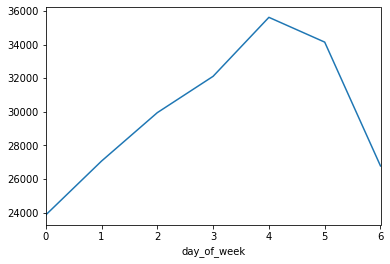

In [12]:
df_ride_deets.groupby(['driver_id', 'day_of_week'])['ride_duration'].agg("sum").reset_index().groupby('day_of_week')['ride_duration'].agg("mean").plot()

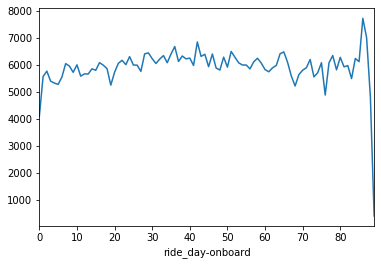

In [13]:
df_ride_deets[df_ride_deets['day_of_week'] < 5].groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()
# waste

In [ ]:
# taking three categories to gind Good Medium Bad based on no of hours daily

In [176]:
# rating based on days driven
k = (df_ride_deets.groupby('driver_id')['ride_day-onboard'].max() - df_ride_deets.groupby('driver_id')['ride_day-onboard'].nunique())/(df_ride_deets.groupby('driver_id')['ride_day-onboard'].max())
k = pd.qcut(k, 3, labels=[3, 2, 1])
def rating_holidays(val):
    return(k[val])
#     if k[val] > 0.7:
#         return 1
#     elif k[val] <= 0.7 and k[val] > 0.3:
#         return 2
#     else:
#         return 3

def daysDrivenFraction(val):
    return k[val]
df_ride_deets['rating_days_off_taken'] = df_ride_deets['driver_id'].map(rating_holidays)
df_ride_deets['daysDrivenFraction'] = df_ride_deets['driver_id'].map(daysDrivenFraction)
df_ride_deets[['driver_id', 'rating_days_off_taken']].drop_duplicates()['rating_days_off_taken'].value_counts()# / df_ride_deets['driver_id'].nunique()


3    279
2    279
1    279
Name: rating_days_off_taken, dtype: int64

In [177]:
# rating based on no of hours driven
k = (df_ride_deets.groupby('driver_id')['ride_duration'].agg('sum')) / df_ride_deets.groupby('driver_id')['ride_day-onboard'].nunique()
k /= 3600
k = pd.qcut(k, 3, labels=[3, 2, 1])

def rating_hoursPerDay(val):
    return k[val]

df_ride_deets['rating_hoursPerDay'] = df_ride_deets['driver_id'].map(rating_hoursPerDay)
df_ride_deets[['driver_id', 'rating_hoursPerDay']].drop_duplicates()['rating_hoursPerDay'].value_counts()

3    279
2    279
1    279
Name: rating_hoursPerDay, dtype: int64

In [178]:
# rating based on time taken to accept
k = df_ride_deets.groupby('driver_id')['accepted-requested'].agg('mean')
k = pd.qcut(k, 3, labels=[1, 2, 3])

def rating_timeToAccept(val):
    return k[val]

df_ride_deets['rating_timeToAccept'] = df_ride_deets['driver_id'].map(rating_timeToAccept)
df_ride_deets[['driver_id', 'rating_timeToAccept']].drop_duplicates()['rating_timeToAccept'].value_counts()

3    279
2    279
1    279
Name: rating_timeToAccept, dtype: int64

In [180]:
df_ride_deets['rating'] = (df_ride_deets['rating_timeToAccept'] + df_ride_deets['rating_hoursPerDay'] + df_ride_deets['rating_days_off_taken']) / 3
df_ride_deets.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,primeMultiplicator,fare,adjusted_fare,accepted_at,arrived_at,...,arrived-accepted,pickedup-arrived,dropped-picked,day_of_week,rating_days_off_taken,daysDrivenFraction,rating_hoursPerDay,rating_timeToAccept,rating,rating_nomalized
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,0.50,9.365063,9.37,2016-04-23 02:14:15,2016-04-23 02:16:36,...,141.0,4.0,327,5,2,2,3,1,2.0,2
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,1.00,18.238509,18.24,2016-03-29 19:00:52,2016-03-29 19:03:57,...,185.0,4.0,809,1,2,2,3,1,2.0,2
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,1.00,16.386152,16.39,2016-06-21 11:56:39,2016-06-21 12:01:32,...,293.0,3.0,572,1,2,2,3,1,2.0,2
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,0.25,78.311286,78.31,2016-05-19 09:15:33,2016-05-19 09:18:20,...,167.0,0.0,3338,3,2,2,3,1,2.0,2
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,1.00,19.417558,19.42,2016-04-20 22:05:32,2016-04-20 22:07:03,...,91.0,86399.0,823,2,2,2,3,1,2.0,2


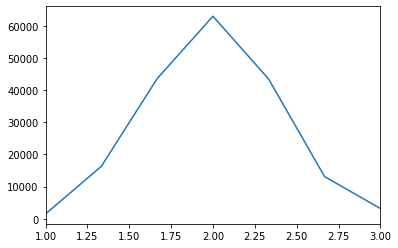

In [181]:
df_ride_deets['rating'].value_counts().sort_index().plot()

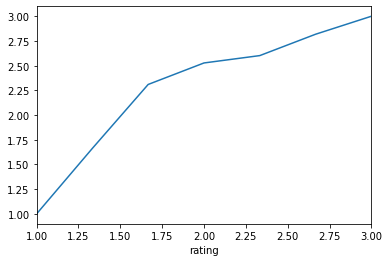

In [182]:
df_ride_deets.groupby('rating')['daysDrivenFraction'].agg('mean').plot()

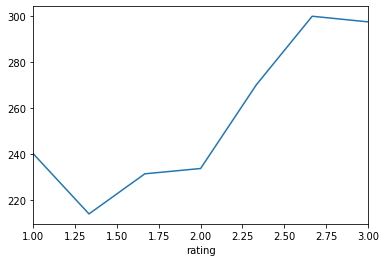

In [183]:
df_ride_deets.groupby('rating')['arrived-accepted'].agg('mean').plot()

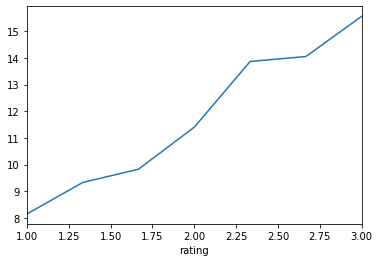

In [184]:
df_ride_deets.groupby('rating')['accepted-requested'].agg('mean').plot()

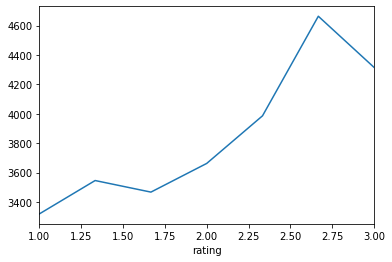

In [185]:
df_ride_deets.groupby('rating')['pickedup-arrived'].agg('mean').plot()

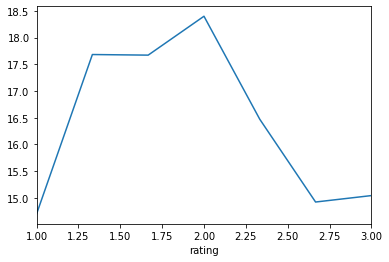

In [186]:
df_ride_deets.groupby('rating')['ride_prime_time'].agg('mean').plot()

In [ ]:
# how does rating change day to day as days from onboard increases

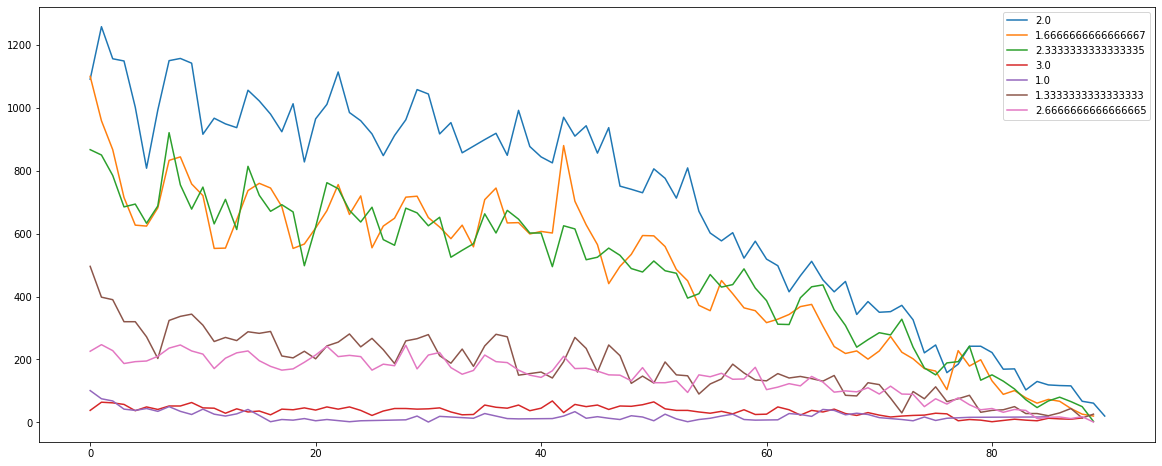

In [239]:
plt.rcParams["figure.figsize"] = [20,8]
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['ride_prime_time'].agg('count'), label = str(i))

plt.legend()

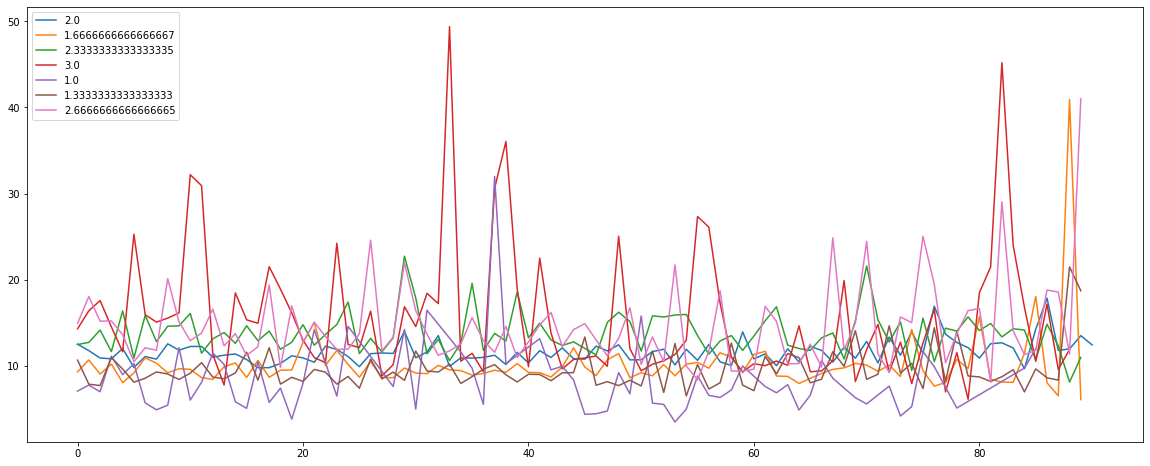

In [240]:
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['accepted-requested'].agg('mean'), label = str(i))

plt.legend()

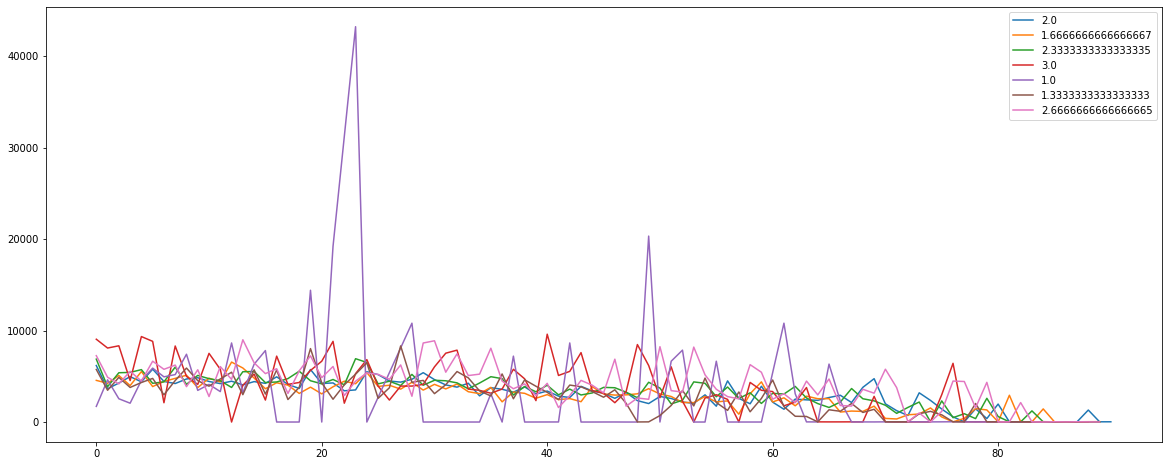

In [241]:
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['pickedup-arrived'].agg('mean'), label = str(i))

plt.legend()

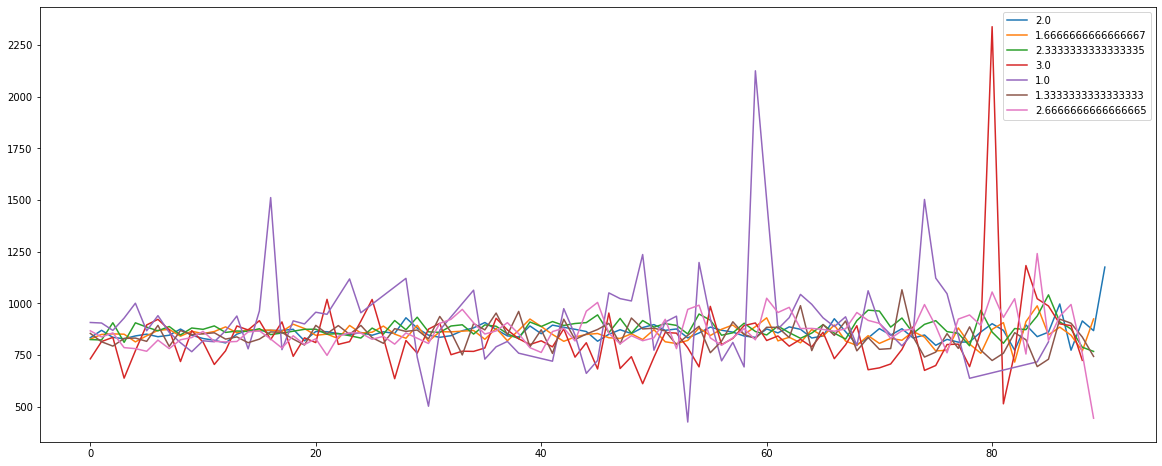

In [242]:
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['ride_duration'].agg('mean'), label = str(i))

plt.legend()

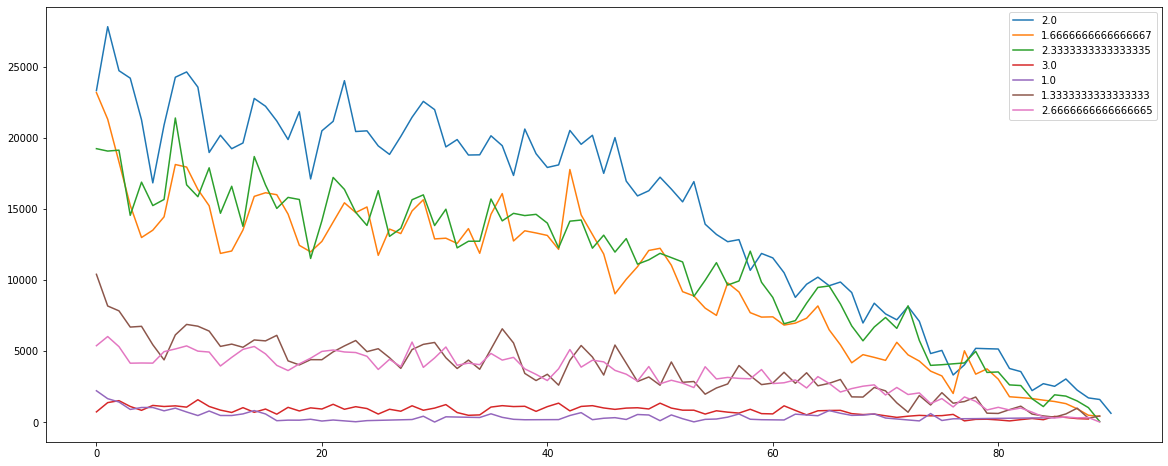

In [243]:
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['adjusted_fare'].agg('sum'), label = str(i))

plt.legend()

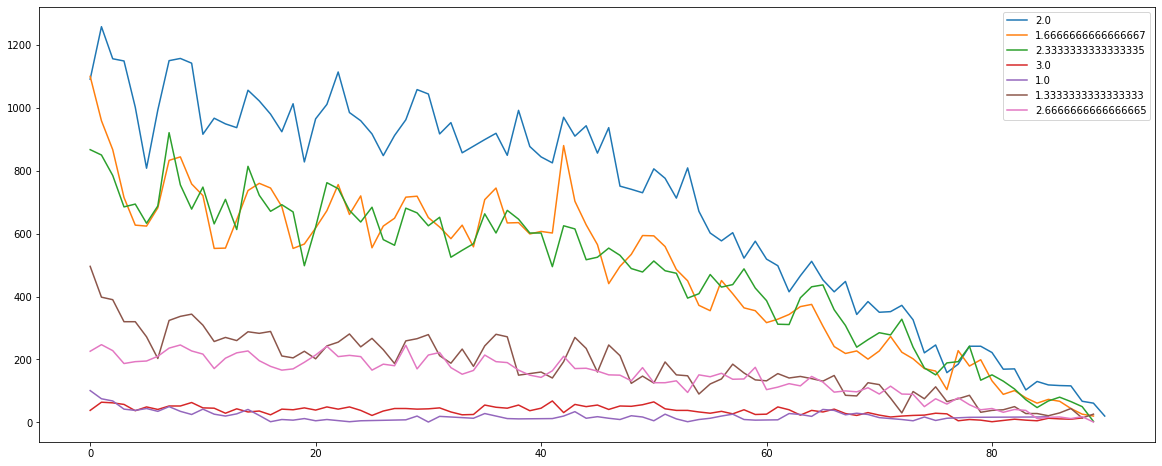

In [249]:
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['day_of_week'].count(), label = str(i))

plt.legend()


In [216]:
df_ride_deets['normalized_rating'] = pd.qcut(df_ride_deets['rating'], 3, labels=[1, 2, 3])

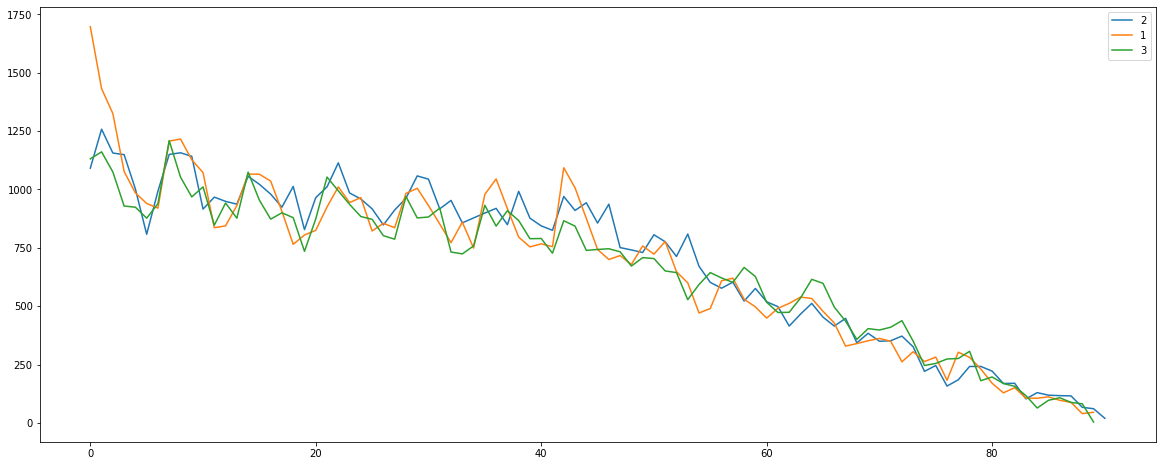

In [248]:
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['day_of_week'].count(), label = str(i))

plt.legend()

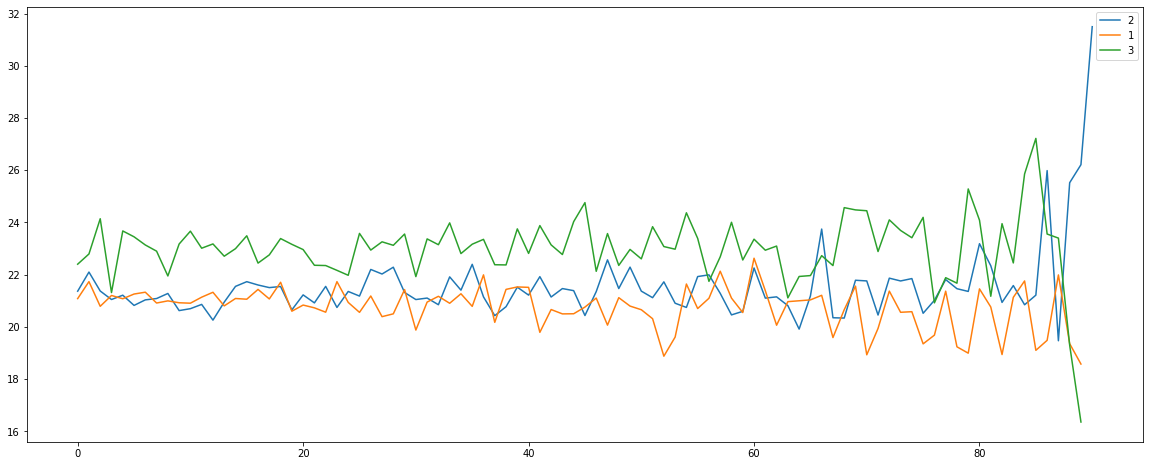

In [247]:
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['adjusted_fare'].agg('mean'), label = str(i))

plt.legend()

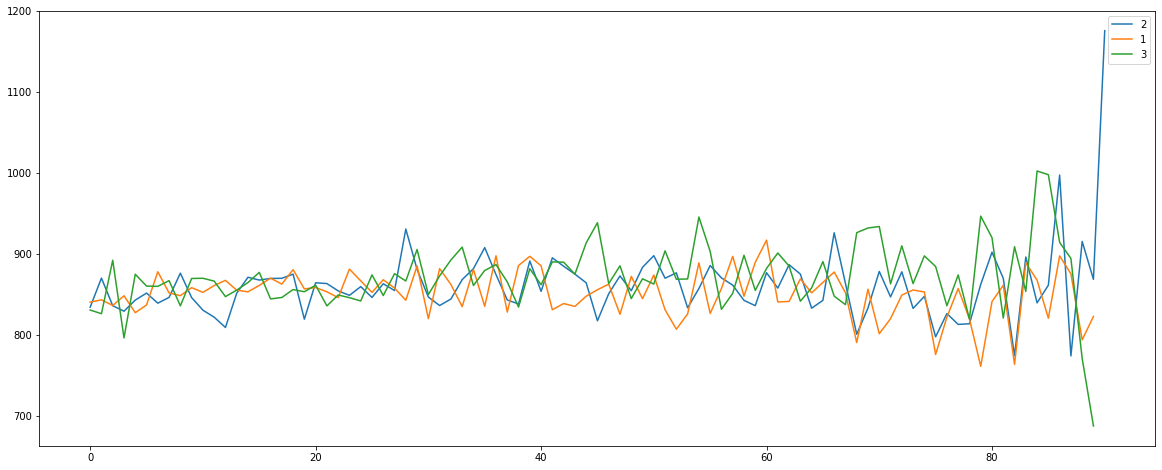

In [246]:
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['ride_duration'].agg('mean'), label = str(i))

plt.legend()

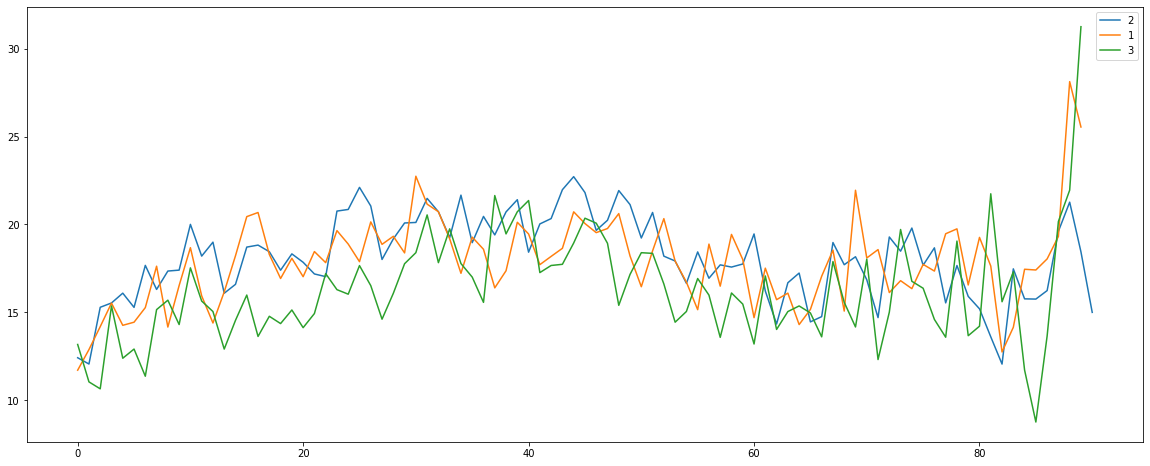

In [245]:
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['ride_prime_time'].agg('mean'), label = str(i))

plt.legend()

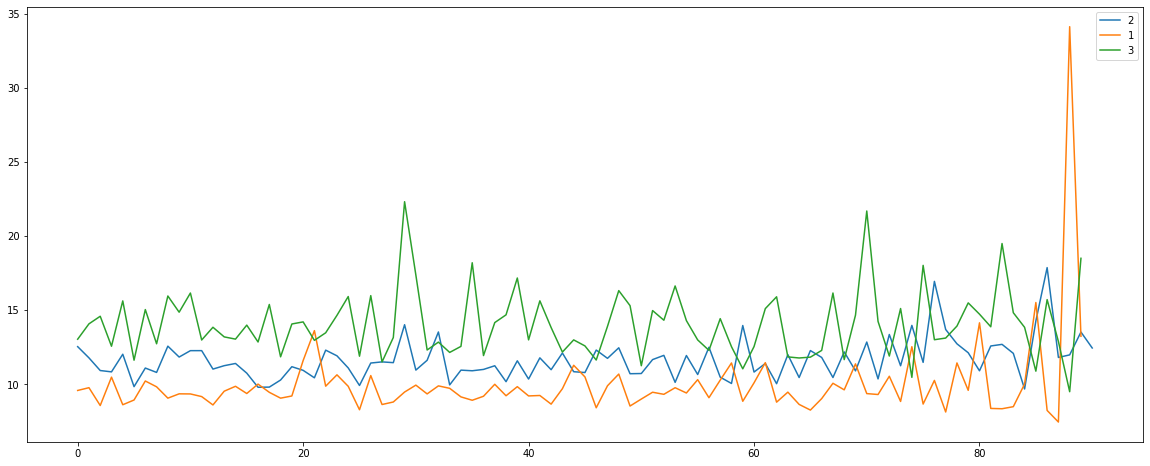

In [244]:
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['accepted-requested'].agg('mean'), label = str(i))

plt.legend()

In [4]:
# ride data given is for every ride completed by driver, hence no cancelled rides
df_ride_whichMonth = df_ride_timestamps.copy(deep = True)

df_ride_whichMonth['YearMonth'] = df_ride_whichMonth['timestamp'].apply(lambda x:x.strftime('%Y-%m')) # get year and month
print(df_ride_whichMonth['YearMonth'].unique())
df_ride_whichMonth = df_ride_whichMonth[df_ride_whichMonth['event'] == 'picked_up_at']


-1
['2016-06' '2016-05' '2016-04' '2016-03']


In [5]:
df_ride_whichMonth.head(5)
df_monthly_money = pd.merge(df_ride_ids, df_ride_whichMonth[['ride_id', 'YearMonth']],
                            left_on = 'ride_id', right_on = 'ride_id')
df_monthly_money = df_monthly_money[['driver_id', 'adjusted_fare', 'YearMonth']]
df_monthly_money.head(5)
df_monthly_money = pd.merge(df_monthly_money, df_driver_ids,
                           left_on = 'driver_id', right_on = 'driver_id')
df_monthly_money['driver_onboard_date']= pd.to_datetime(df_monthly_money['driver_onboard_date'])
df_monthly_money['onborad_YearMonth'] = df_monthly_money['driver_onboard_date'].apply(lambda x:x.strftime('%Y-%m'))
df_monthly_money.head(5)

,driver_id,adjusted_fare,YearMonth,driver_onboard_date,onborad_YearMonth
0,002be0ffdc997bd5c50703158b7c2491,9.37,2016-04,2016-03-29,2016-03
1,002be0ffdc997bd5c50703158b7c2491,18.24,2016-03,2016-03-29,2016-03
2,002be0ffdc997bd5c50703158b7c2491,16.39,2016-06,2016-03-29,2016-03
3,002be0ffdc997bd5c50703158b7c2491,78.31,2016-05,2016-03-29,2016-03
4,002be0ffdc997bd5c50703158b7c2491,19.42,2016-04,2016-03-29,2016-03


In [6]:
def month_number(d1):
    k = d1['onborad_YearMonth']
    j = d1['YearMonth']
    d1 = [int(i) for i in k.split('-')]
    d2 = [int(i) for i in j.split('-')]
    
    if d2[1] < d1[1]:
        return d2[1] + 12 - d1[1] + (d2[0] - d1[0] - 1)*12
    else:
        return (d2[0] - d1[0])*12 + d2[1] - d1[1]

df_monthly_money['month_number'] = df_monthly_money[['onborad_YearMonth','YearMonth']].apply(month_number, axis = 1)
df_monthly_money.head(5)
print(df_monthly_money['onborad_YearMonth'].unique())

['2016-03' '2016-04' '2016-05']


In [7]:
print(df_monthly_money.head(5))

                          driver_id  adjusted_fare YearMonth  \
0  002be0ffdc997bd5c50703158b7c2491           9.37   2016-04   
1  002be0ffdc997bd5c50703158b7c2491          18.24   2016-03   
2  002be0ffdc997bd5c50703158b7c2491          16.39   2016-06   
3  002be0ffdc997bd5c50703158b7c2491          78.31   2016-05   
4  002be0ffdc997bd5c50703158b7c2491          19.42   2016-04   

  driver_onboard_date onborad_YearMonth  month_number  
0          2016-03-29           2016-03             1  
1          2016-03-29           2016-03             0  
2          2016-03-29           2016-03             3  
3          2016-03-29           2016-03             2  
4          2016-03-29           2016-03             1  


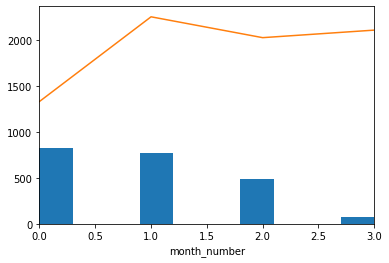

In [8]:
df_monthly_avgs = df_monthly_money.groupby(['driver_id', 'month_number'])['adjusted_fare'].agg("sum").reset_index()
df_monthly_avgs['month_number'].hist()
df_monthly_avgs.groupby('month_number')['adjusted_fare'].agg("mean").plot()

#### We have been given 3 months data, hence analysis needs to be granular at day level and then time level. So far we see that the data we have is between March 2016 - May 2016. Hence our analysis is about seeing the trends in a driver's productivity over these three months and elucidate what it will continue to be.

#### We can say that drivers don't saty for long, and maximum churn is between their second and third month. The problem with the histogram is that more no of drivers have the option of having their third month evaluated than not, because some drivers that join in May 2016 wouldn't have completed enough time to show up on the map. 

#### So we first see the no of drivers joining each month.

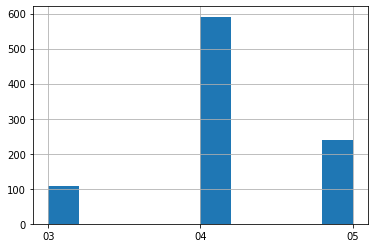

In [9]:
df_driver_ids_c = df_driver_ids.copy(deep = True)
df_driver_ids_c['onborad_month'] = df_driver_ids_c['driver_onboard_date'].apply(lambda x:x.strftime('%m'))

df_driver_ids_c['onborad_month'].hist()

In [63]:
df_ride_whichMonth = df_ride_timestamps.copy(deep = True)
df_ride_whichMonth = df_ride_whichMonth.dropna(how = "any")
# df_ride_whichMonth = df_ride_whichMonth[df_ride_whichMonth['event'] == 'picked_up_at']
df_monthly_money = pd.merge(df_ride_ids, df_ride_timestamps,
                            left_on = 'ride_id', right_on = 'ride_id')
df_monthly_money = pd.merge(df_driver_ids, df_monthly_money,
                            left_on = 'driver_id', right_on = 'driver_id')
df_daily_money =  df_monthly_money.copy(deep = True)

def getDeltaDays(val1):
    d1 = val1['timestamp']
    d2 = val1['driver_onboard_date']
    return (d1 - d2).days

df_daily_money['deltaDays'] = df_daily_money[['timestamp', 'driver_onboard_date']].apply(getDeltaDays, axis = 1)
print(df_daily_money.head(5))

                          driver_id driver_onboard_date  \
0  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
1  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
2  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
3  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
4  002be0ffdc997bd5c50703158b7c2491          2016-03-29   

                            ride_id  ride_distance  ride_duration  \
0  006d61cf7446e682f7bc50b0f8a5bea5           1811            327   
1  01b522c5c3a756fbdb12e95e87507eda           3362            809   
2  029227c4c2971ce69ff2274dc798ef43           3282            572   
3  034e861343a63ac3c18a9ceb1ce0ac69          65283           3338   
4  034f2e614a2f9fc7f1c2f77647d1b981           4115            823   

   ride_prime_time  primeMultiplicator       fare  adjusted_fare  \
0               50                0.50   9.365063           9.37   
1                0                1.00  18.238509          18.24   
2                0        

In [62]:
df_monthly_money['driver_id'].nunique()

844

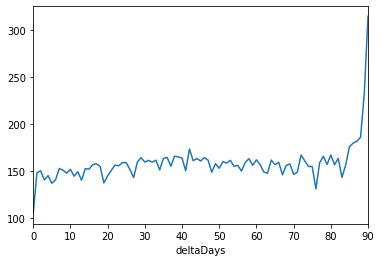

In [11]:
# df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("sum").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean")
df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("sum").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean").plot()

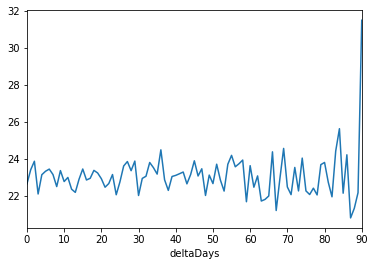

In [159]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("mean").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean").plot()

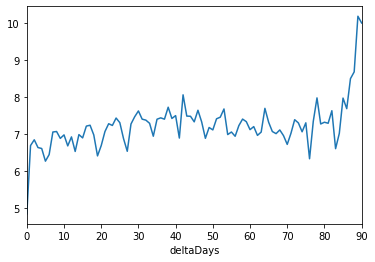

In [162]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['ride_prime_time'].count().reset_index().groupby('deltaDays')['ride_prime_time'].agg("mean").plot()

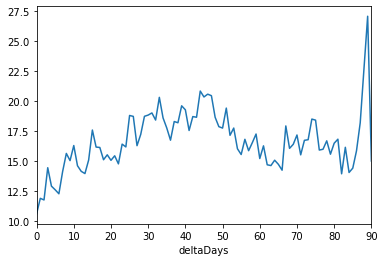

In [163]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['ride_prime_time'].agg("mean").reset_index().groupby('deltaDays')['ride_prime_time'].agg("mean").plot()

In [45]:
df_daily_money['deltaDays'].value_counts()[:30]

0     3902
1     3857
7     3566
2     3556
8     3417
9     3245
14    3195
3     3155
22    3125
15    3044
10    3003
21    2992
29    2937
42    2927
4     2918
28    2918
16    2888
30    2861
23    2859
6     2852
35    2807
36    2806
24    2804
43    2764
13    2739
12    2737
17    2731
31    2689
37    2674
18    2660
Name: deltaDays, dtype: int64

In [49]:
df_daily_money['driver_id'].nunique()

837

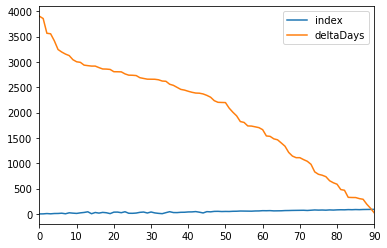

In [43]:
df_daily_money['deltaDays'].value_counts().reset_index().plot()

In [ ]:
df_ride_deets= df_ride_timestamps.pivot(index='ride_id',columns='event',values='timestamp')

In [ ]:
print(df_ride_deets)

In [ ]:
df_ride_deets["time_to_accept"] = 